In [142]:
library("TSP")
concorde_path("~/concorde/TSP")

found: concorde concorde.c concorde.o 


In [184]:

library("hash")
library("sets")

dataTSP <- read_TSPLIB("/home/LC/mailo01/TSP-ML-Approach/src/R/CLUSTER_DIV/main.tsp")


pointSet <- hash()
noPts <- length(dataTSP)/2
for (i in 1:noPts){
    pointSet[[toString(i)]] <- tuple(dataTSP[i], dataTSP[i+noPts])
}

dist_pts <- function(pt1,pt2){
        return(sqrt((pt1[[1]]-pt2[[1]])^2 + (pt1[[2]]-pt2[[2]])^2))
}

angle <- function(x,y){
  dot.prod <- x%*%y 
  norm.x <- norm(x,type="2")
  norm.y <- norm(y,type="2")
  theta <- acos(dot.prod / (norm.x * norm.y))
  as.numeric(theta)
}

angle_pts <- function(pt1,pt2){
    
    if (pt1[[2]] -pt2[[2]] == 0){
        if (pt1[[1]] -pt2[[1]]>0){
            return(pi/2)
        }
        if (pt1[[1]] -pt2[[1]]<0){
            return(-pi/2)
        }
        if (pt1[[1]] -pt2[[1]]==0){
            return(0)
        }
    } else{
        x<- pt1[[1]] -pt2[[1]]
        y <-pt1[[2]] -pt2[[2]]
        angle <- atan((y)/(x))
        if (x < 0 & y>0){
            angle <- pi + angle
        }
        if (x >0 & y <0){
            angle <-2*pi +angle
        }
        if (x < 0 & y<0){
            angle <- pi + angle
        }
        return(angle)
        }
}


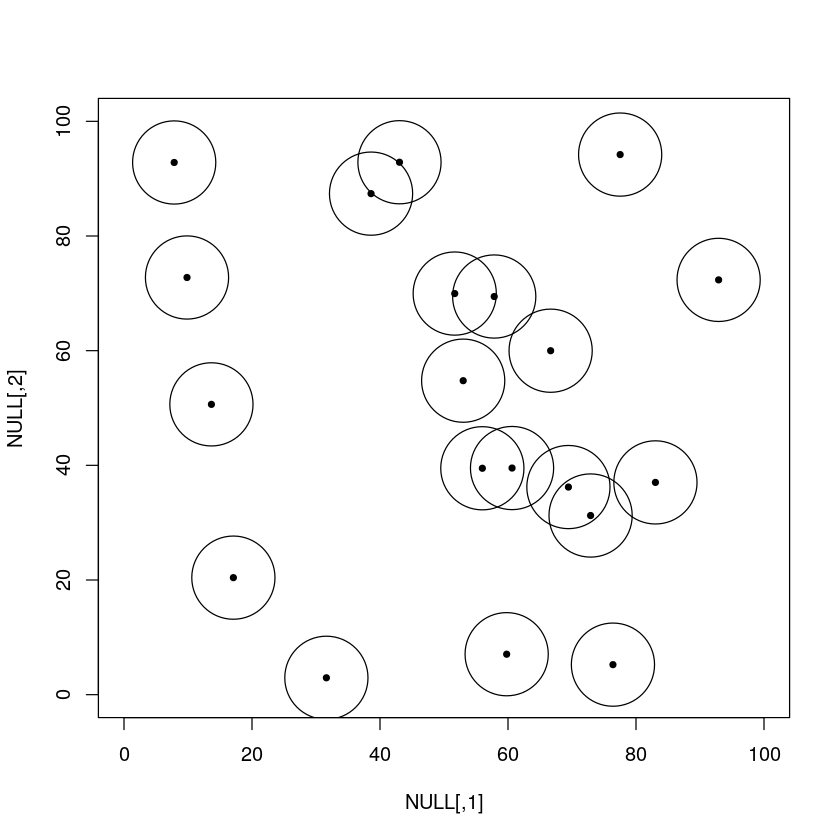

In [185]:
radius <-6.5
plot(dataTSP, xlim=c(0,100), ylim=c(0,100), pch=20)
symbols(dataTSP,circles=rep(radius,noPts), add=T, inches=F)


In [186]:
pivot_point <- values(pointSet, keys =1)

angle_based <- list()
distance_based <-list()

for (i in 1:noPts){
    compare_point <- values(pointSet, keys= i)
    element <-list(list(i, dist_pts(pivot_point,compare_point), angle_pts(compare_point,pivot_point)))
    angle_based <- append(angle_based, element)
    distance_based <- append(distance_based, element)
}




In [187]:
start_time <- Sys.time()

angle_based <- angle_based[order(sapply(distance_based, '[[', 3))]
end_time <- Sys.time()
end_time - start_time

Time difference of 0.003186226 secs

In [188]:
start_time <- Sys.time()

distance_based <- distance_based[order(sapply(distance_based,'[[',2))]
end_time <- Sys.time()
end_time - start_time

Time difference of 0.003191471 secs

In [189]:
get_item <- function(item_to_get, database){
    counter <-1
    cont <- TRUE 
    while (counter <= length(database) & cont == TRUE){
        data_pt <-database[[counter]]
        if (data_pt[1] == item_to_get){
            return(data_pt)
            cont <- FALSE
        }
        counter <- counter +1
    }
}

get_pts_range_dist <- function(lower_bound, higher_bound){
    cont = TRUE
    counter <-1
    eligible_vertices <-list()
    while (counter <= length(distance_based) & cont ==TRUE){
        distance_wrt_pivot <- distance_based[[counter]]
        
        if (distance_wrt_pivot[[2]] >= lower_bound & distance_wrt_pivot[[2]]<= higher_bound){
            eligible_vertices <- append(eligible_vertices, distance_wrt_pivot[[1]])
        }
        if (distance_wrt_pivot[[2]]> higher_bound){
            cont <- FALSE
        }
        counter <- counter +1
    }
    return(eligible_vertices)
}

obtain_angle_range <- function(lower_bound, higher_bound){
    cont = TRUE
    counter <-1
    eligible_vertices <-list()
    while (counter <= length(angle_based) & cont ==TRUE){
        angle_wrt_hor <- angle_based[[counter]]
        
        if (angle_wrt_hor[[3]] >= lower_bound & angle_wrt_hor[[3]]<= higher_bound){
            eligible_vertices <- append(eligible_vertices, angle_wrt_hor[[1]])
        }
        if (angle_wrt_hor[[3]]> higher_bound){
            cont <- FALSE
        }
        counter <- counter +1
    }
    print(eligible_vertices)
    return(eligible_vertices)
}

conform_angle <- function(angle){
    if (angle <0){
        angle <- 2*pi + angle
    }
    if (angle >2*pi){
        angle <- angle - 2*pi
    }
    
    return(angle)
}

get_pts_range_angle <- function(distance_from_pivot, radius, angle){
     eligible_vertices <-list()
    if (distance_from_pivot < 2*radius){
        print("point within 2*radius, angle sort doesn't provide another limit factor")
        for (point in 1:length(angle_based)){
            eligible_vertices <- append(eligible_vertices, angle_based[[point]][1])
            }
    }else{
        if (2*radius == distance_from_pivot){
            #r = d, gives the angle range that is 180 degrees. Gives which side?
            print("distance is 2*radius, will yield the 180 degree angle")
            higher_bound <- conform_angle(pi/2 - (pi - angle))
            lower_bound<- conform_angle(higher_bound + pi)
            print("the lower_bound is")
            print(lower_bound)
            print("the higher_bound is")
            print(higher_bound)
            eligible_vertices <- append(eligible_vertices, obtain_angle_range(lower_bound, higher_bound))
            print("elgible vertices in angle sort")
        }else{
            #r > d
            print("distance is larger than 2*radius")
            phi <- asin(2*radius/distance_from_pivot)
            if (angle + phi > 2*pi){
                diff <-  angle + phi -2*pi 
                eligible_vertices <- append(eligible_vertices, obtain_angle_range(0,diff))
                eligible_vertices <- append(eligible_vertices, obtain_angle_range(angle-phi, 2*pi))
                print("the lower_bound is")
                print(angle-phi)
                print("the higher_bound is")
                print(diff)
            } else {
                if (angle - phi < 0){
                    diff <- angle - phi 
                    eligible_vertices <- append(eligible_vertices, obtain_angle_range(2*pi + diff, 2*pi))
                    eligible_vertices <- append(eligible_vertices, obtain_angle_range(0, angle+phi))
                    print("the lower_bound is")
                    print(2*pi +diff)
                    print("the higher_bound is")
                    print(angle+phi)
                }else{
                    eligible_vertices <- append(eligible_vertices, obtain_angle_range(angle-phi, angle+phi))
                    print("the lower_bound is")
                    print(angle-phi)
                    print("the higher_bound is")
                    print(angle+phi)
                }
            }
        }
    }    
    return(eligible_vertices)

}

In [190]:
start_time <- Sys.time()
current_tree <- list()
checklist <-(c(1:noPts))
while (length(checklist) != 0){

    branch <- list()
    
    old_branch_len<- length(branch)

    startPt = checklist[1]
    branch<-append(branch, startPt)

    counter =1

    while(old_branch_len != length(branch)){

        current_branch_len <- length(branch)
        
        start <-old_branch_len+1
        pts_to_connect <- c(branch[start:current_branch_len])


        checklist <-checklist[!checklist %in% pts_to_connect]

        old_branch_len= current_branch_len

        for (connect_pt in pts_to_connect){
            ## to yield an estimates of near by points 
            pivot_data <- get_item(connect_pt, distance_based)
            dist_wrt_pivot <- pivot_data[[2]][1]
            angle_wrt_hor <-pivot_data[[3]][1]
            print("point to connect is")
            print(connect_pt)
            
            if (dist_wrt_pivot == 0){
                possible_connect <- get_pts_range_dist(0,2*radius)
                print("point to connect is the same as pivot. yielding proximity possible results only")
                print(possible_connect)
            } else {
                
                possible_angle <- get_pts_range_angle(dist_wrt_pivot, radius, angle_wrt_hor)
                print("possible vertices based on angle sorting")
                print(possible_angle)
                possible_dist <- get_pts_range_dist(dist_wrt_pivot-2*radius, dist_wrt_pivot+2*radius)
                print("possible vertices based on distance sorting")
                print(possible_dist)
                possible_connect <- intersect(possible_angle, possible_dist)
            }
            print("intersect list to compare")
            print(possible_connect)
            for (comparePt in possible_connect){

                if (!comparePt %in%branch){
                    vPt1 <-values(pointSet, keys=connect_pt) 
                    vPt2 <-values(pointSet, keys=comparePt) 
                    
                    if (dist_pts(vPt1,vPt2) <= 2*radius){
                        
                        branch<-append(branch,comparePt)
                        print("pt within range")
                        print(comparePt)
                        checklist <-checklist[!checklist %in% c(comparePt)]

                        
                    } else {}
                } else{}
            }
        }
        counter <- counter +1
        
    }
    current_tree <- append(current_tree, list(branch))
}
end_time <- Sys.time()
end_time - start_time


[1] "point to connect is"
[1] 1
[1] "point to connect is the same as pivot. yielding proximity possible results only"
[[1]]
[1] 1

[1] "intersect list to compare"
[[1]]
[1] 1

[1] "point to connect is"
[1] 2
[1] "distance is larger than 2*radius"
[[1]]
[1] 13

[[2]]
[1] 16

[[3]]
[1] 2

[[4]]
[1] 3

[[5]]
[1] 5

[[6]]
[1] 17

[1] "the lower_bound is"
[1] 1.195712
[1] "the higher_bound is"
[1] 1.687735
[1] "possible vertices based on angle sorting"
[[1]]
[1] 13

[[2]]
[1] 16

[[3]]
[1] 2

[[4]]
[1] 3

[[5]]
[1] 5

[[6]]
[1] 17

[1] "possible vertices based on distance sorting"
[[1]]
[1] 6

[[2]]
[1] 11

[[3]]
[1] 2

[[4]]
[1] 5

[[5]]
[1] 10

[[6]]
[1] 15

[1] "intersect list to compare"
[[1]]
[1] 2

[[2]]
[1] 5

[1] "pt within range"
[1] 5
[1] "point to connect is"
[1] 5
[1] "distance is larger than 2*radius"
[[1]]
[1] 2

[[2]]
[1] 3

[[3]]
[1] 5

[[4]]
[1] 17

[[5]]
[1] 10

[[6]]
[1] 11

[[7]]
[1] 18

[1] "the lower_bound is"
[1] 1.392129
[1] "the higher_bound is"
[1] 1.811748
[1] "po

Time difference of 0.1955025 secs

In [191]:
current_tree

[[1]]
[[1]][[1]]
[1] 1


[[2]]
[[2]][[1]]
[1] 2

[[2]][[2]]
[1] 5

[[2]][[3]]
[1] 10


[[3]]
[[3]][[1]]
[1] 3

[[3]][[2]]
[1] 13

[[3]][[3]]
[1] 17

[[3]][[4]]
[1] 14

[[3]][[5]]
[1] 7


[[4]]
[[4]][[1]]
[1] 4


[[5]]
[[5]][[1]]
[1] 6


[[6]]
[[6]][[1]]
[1] 8

[[6]][[2]]
[1] 18


[[7]]
[[7]][[1]]
[1] 9


[[8]]
[[8]][[1]]
[1] 11


[[9]]
[[9]][[1]]
[1] 12


[[10]]
[[10]][[1]]
[1] 15


[[11]]
[[11]][[1]]
[1] 16


[[12]]
[[12]][[1]]
[1] 19


[[13]]
[[13]][[1]]
[1] 20

1       
[1,] 59.79141
[2,] 7.056561

[1] 27.51698

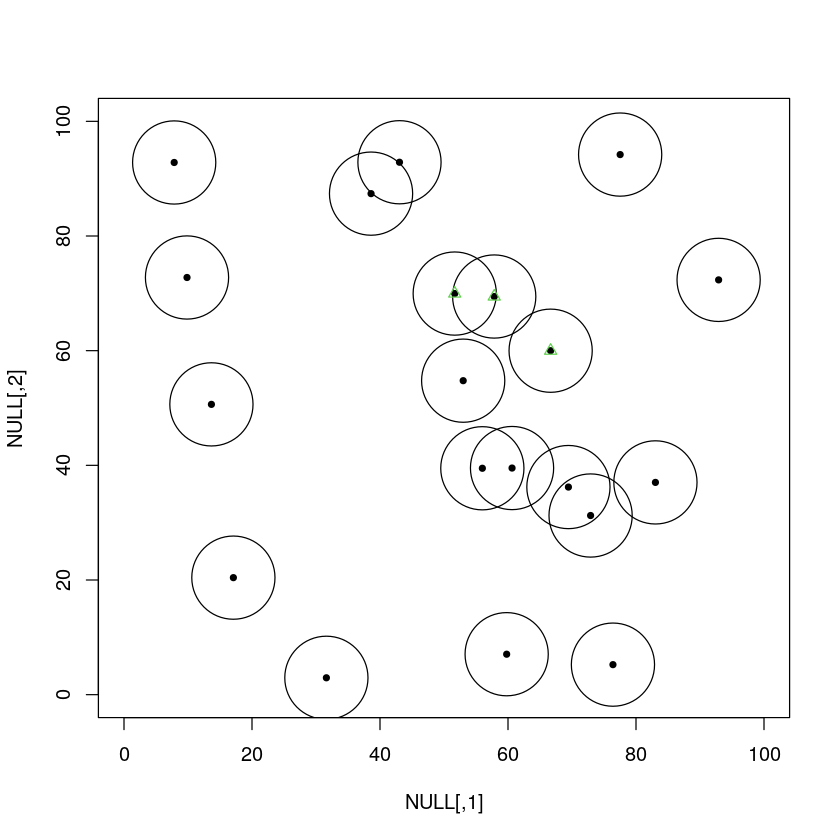

In [192]:
plot(dataTSP,xlim=c(0,100), ylim=c(0,100), pch=20)
symbols(dataTSP, circles=rep(radius,noPts), add=T, inches=F)
branchNo = 2
for (all in current_tree[[branchNo]]){
    pt <- values(pointSet, keys =all)
    points(pt[[1]],pt[[2]], col="3", pch=2)
}

manual_pt <- values(pointSet, keys =1)
#points(manual_pt[[1]],manual_pt[[2]], col="2", pch=5)
check <- c(9, 14)
for (pt in check){
    #manual_pt <- values(pointSet, keys =pt)
    #points(manual_pt[[1]],manual_pt[[2]], col="4", pch=3)
}

vPt1 <-values(pointSet, keys=1) 
vPt2 <-values(pointSet, keys=14) 
vPt3 <-values(pointSet, keys =12)
#dist_pts(vPt1,vPt2)

vPt1
#vPt2
#vPt3
#angle_pts(vPt2,vPt1)
#dist_pts(vPt2,vPt1)
#angle_pts(vPt3,vPt1)
dist_pts(vPt2,vPt1)
#dist_pts(vPt2,vPt3)

ls | grep 'branch\_[0-9]*\_case\_[0-9]*\.tsp'
use this command to select case based in order to run concorde with

In [193]:
convert_sol_format <- function(content){
    content <- content[-1]
    for (index in 1:length(content)){
        content[[index]] <- content[[index]] + 1
    }
    return(as.TOUR(as.integer(content)))
}

In [194]:
content<- scan("main.sol")
Rtour <- convert_sol_format(content)
Rtour

object of class ‘TOUR’ 
result of method  for 20 cities
tour length: unknown

[1] NA

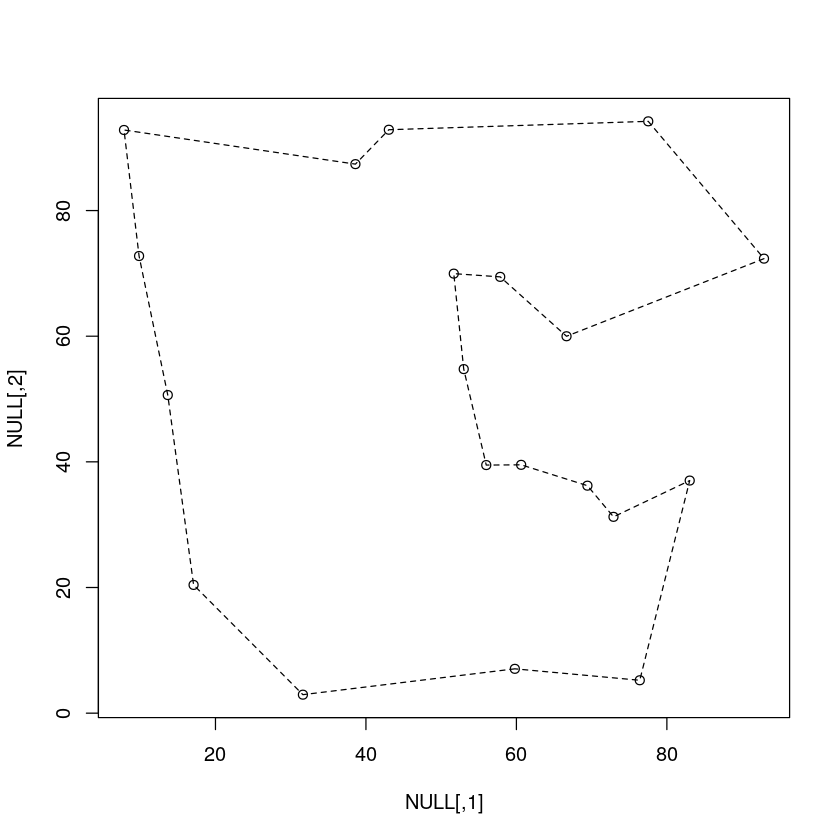

In [195]:
plot(dataTSP, Rtour)
tour_length(Rtour)

In [196]:
tsp <- as.TSP(dataTSP)
as.dist(tsp)


            1          2          3          4          5          6          7
2   53.379791                                                                  
3   32.481211  21.335310                                                       
4  100.272978  67.362126  75.015238                                            
5   62.417945  12.924035  30.046627  55.200910                                 
6   44.739986  63.435030  47.552692  73.000905  63.760524                      
7   37.924963  28.208093  22.543486  93.636518  41.055883  68.005372           
8   83.080136  39.216776  52.688870  31.236039  26.313888  70.347854  67.164981
9   82.535104  58.234580  60.695859  20.159536  48.117217  52.851910  81.451187
10  63.424597  17.997752  31.723315  49.438720   6.192746  60.425839  45.478101
11  48.189894  14.629523  17.043552  59.054974  15.459320  49.694750  34.886349
12  73.209212  29.009572  46.032203  87.497168  35.181699  91.900977  36.677439
13  30.709378  23.943249   9.411582  83.

In [197]:
tsp <-insert_dummy(tsp, 1, const =c(Inf,Inf,Inf,Inf, Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf, Inf,Inf,0,Inf,Inf,Inf,0), inf = Inf, label = "dummy")

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [20] is not a sub-multiple or multiple of the number of columns [21]”


In [198]:
as.dist(tsp)

               1          2          3          4          5          6
2      53.379791                                                       
3      32.481211  21.335310                                            
4     100.272978  67.362126  75.015238                                 
5      62.417945  12.924035  30.046627  55.200910                      
6      44.739986  63.435030  47.552692  73.000905  63.760524           
7      37.924963  28.208093  22.543486  93.636518  41.055883  68.005372
8      83.080136  39.216776  52.688870  31.236039  26.313888  70.347854
9      82.535104  58.234580  60.695859  20.159536  48.117217  52.851910
10     63.424597  17.997752  31.723315  49.438720   6.192746  60.425839
11     48.189894  14.629523  17.043552  59.054974  15.459320  49.694750
12     73.209212  29.009572  46.032203  87.497168  35.181699  91.900977
13     30.709378  23.943249   9.411582  83.661735  35.197216  54.681598
14     27.516979  29.414477  14.804096  89.580566  41.056926  56

In [199]:
tour <- solve_TSP(tsp, method="concorde")


Used control parameters:
clo	 =  
exe	 =  /home/LC/mailo01/concorde/TSP/concorde
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


Warning message in .prepare_dist_concorde(x, MAX, control$precision):
“Concorde/Linken can only handle distances represented as integers. Converting the provided distances to integers with precison 5. This may lead to rounding errors.”


In [200]:
tour[]

1    14    13     3    17    11     2     5    10    18     8     4     9 
    1    14    13     3    17    11     2     5    10    18     8     4     9 
   15     6    20 dummy    16    12     7    19 
   15     6    20    21    16    12     7    19 
attr(,"method")
[1] "concorde"
attr(,"tour_length")
[1] 368.0365

[1] 368.0365

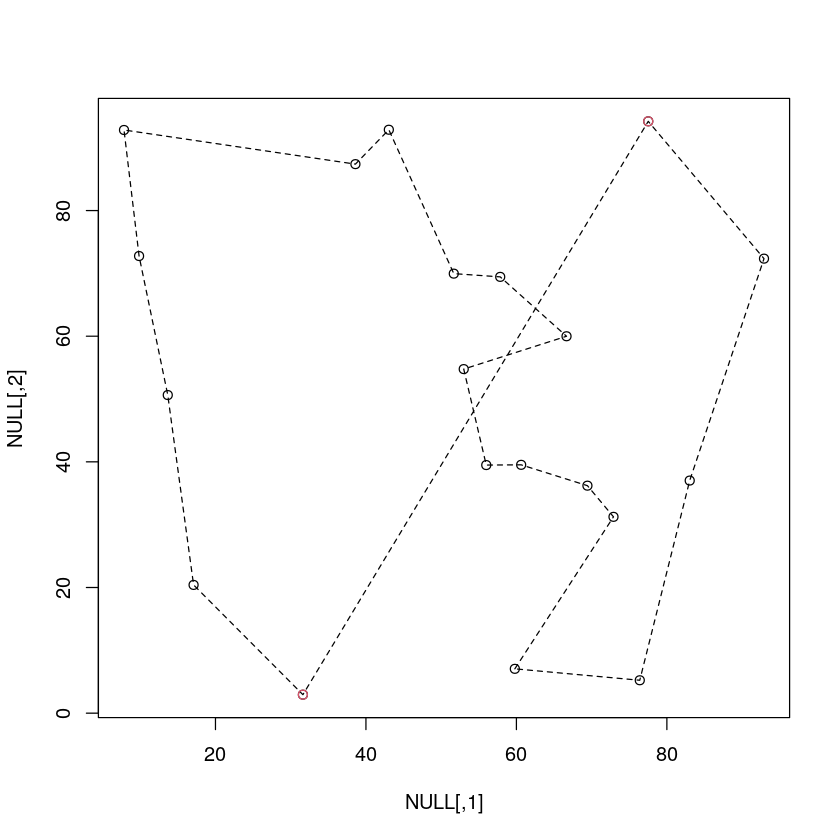

In [201]:
plot(dataTSP, tour[-17])
tour_length(tour)
pt1 <- values(pointSet, keys=20)
points(pt1[[1]],pt1[[2]], col="2")
pt2 <- values(pointSet, keys=16)
points(pt2[[1]],pt2[[2]], col="2")
 


In [202]:
data <- data.frame(10*runif(10), 10*runif(10), 10)
data

X10...runif.10.,X10...runif.10..1,X10
<dbl>,<dbl>,<dbl>
4.980602,6.506016,10
1.087324,5.982307,10
5.367395,1.577494,10
8.830192,7.523799,10
1.190283,9.601278,10
6.842656,1.436449,10
2.727420,2.621283,10
9.024190,6.301025,10
9.802135,5.667724,10


In [203]:
tsp <- as.TSP(dataTSP)
obj <-as.dist(tsp)
nrow(as.matrix(tsp))


[1] 20

In [204]:
obj[[20]]

[1] 21.33531

In [205]:
no <- 5
x <- matrix(rep(0,no^2),nrow=no)
x[[1]]

[1] 0

In [206]:
current_tree

[[1]]
[[1]][[1]]
[1] 1


[[2]]
[[2]][[1]]
[1] 2

[[2]][[2]]
[1] 5

[[2]][[3]]
[1] 10


[[3]]
[[3]][[1]]
[1] 3

[[3]][[2]]
[1] 13

[[3]][[3]]
[1] 17

[[3]][[4]]
[1] 14

[[3]][[5]]
[1] 7


[[4]]
[[4]][[1]]
[1] 4


[[5]]
[[5]][[1]]
[1] 6


[[6]]
[[6]][[1]]
[1] 8

[[6]][[2]]
[1] 18


[[7]]
[[7]][[1]]
[1] 9


[[8]]
[[8]][[1]]
[1] 11


[[9]]
[[9]][[1]]
[1] 12


[[10]]
[[10]][[1]]
[1] 15


[[11]]
[[11]][[1]]
[1] 16


[[12]]
[[12]][[1]]
[1] 19


[[13]]
[[13]][[1]]
[1] 20

In [207]:
mat <- as.matrix(as.TSP(dataTSP))
mat

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,0.00000,53.37979,32.481211,100.27298,62.417945,44.73999,37.92496,83.080136,82.53510,63.424597,48.18989,73.20921,30.709378,27.516979,63.45991,88.93053,32.65362,87.426840,16.70609,28.46772
2,53.37979,0.00000,21.335310,67.36213,12.924035,63.43503,28.20809,39.216776,58.23458,17.997752,14.62952,29.00957,23.943249,29.414477,53.82255,35.89193,23.11436,40.476883,55.61427,66.95037
3,32.48121,21.33531,0.000000,75.01524,30.046627,47.55269,22.54349,52.688870,60.69586,31.723315,17.04355,46.03220,9.411582,14.804096,48.26803,57.22431,4.64065,56.162462,37.74085,46.68948
4,100.27298,67.36213,75.015238,0.00000,55.200910,73.00091,93.63652,31.236039,20.15954,49.438720,59.05497,87.49717,83.661735,89.580566,42.58855,69.69541,71.85395,35.201960,111.22637,92.97257
5,62.41794,12.92403,30.046627,55.20091,0.000000,63.76052,41.05588,26.313888,48.11722,6.192746,15.45932,35.18170,35.197216,41.056926,48.02541,31.62378,30.01336,27.706498,66.83335,71.48511
6,44.73999,63.43503,47.552692,73.00091,63.760524,0.00000,68.00537,70.347854,52.85191,60.425839,49.69475,91.90098,54.681598,56.856269,30.41745,95.37922,43.32684,76.961680,61.21755,22.72155
7,37.92496,28.20809,22.543486,93.63652,41.055883,68.00537,0.00000,67.164981,81.45119,45.478101,34.88635,36.67744,13.620219,11.661644,70.69926,57.44328,27.15663,68.684861,32.47184,61.68291
8,83.08014,39.21678,52.688870,31.23604,26.313888,70.34785,67.16498,0.000000,32.26226,21.788130,35.65907,56.35246,59.751245,65.791462,44.41921,39.51374,50.95961,7.050707,90.42972,84.73354
9,82.53510,58.23458,60.695859,20.15954,48.117217,52.85191,81.45119,32.262258,0.00000,41.925200,46.75605,83.06542,69.911819,75.498792,22.45591,70.99293,56.89230,38.809952,94.81112,73.13753
10,63.42460,17.99775,31.723315,49.43872,6.192746,60.42584,45.47810,21.788130,41.92520,0.000000,15.25201,41.30204,38.138507,44.150360,42.64733,35.43636,30.77556,24.477208,69.28363,69.95261


In [208]:
branch_no <- length(current_tree)
cluster_mat <- matrix(rep(0,branch_no^2),nrow=branch_no)
cluster_mat
nrow(cluster_mat)

0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0


[1] 13

In [209]:
add_data_mat <- function(cluster1_pos,cluster2_pos,value, mat){
    position1 <- (cluster1_pos -1)*nrow(mat) + cluster2_pos
    position2 <- (cluster2_pos -1)*nrow(mat) + cluster1_pos
    mat[[position1]] <- value
    mat[[position2]] <- value
    return(mat)
}

In [210]:
#for each branch, need to find the shortest distance 
#remember, have to put points already taken out of consideration

connections <- hash()

for (branch_index in 1:branch_no){
    #other branches to be compared to
        for (branch_compare_ind in 1:length(current_tree)){
            if (has.key(sprintf("%s-%s",branch_index,branch_compare_ind),connections) == FALSE){

            if (branch_index != branch_compare_ind){
                minimum_dist <- Inf
                connect_pts <- NULL

                for (vertex in current_tree[[branch_index]]){

                    for (vertex_compare in current_tree[[branch_compare_ind]]){
                        vPt1 <-values(pointSet, keys=vertex) 
                        vPt2 <-values(pointSet, keys=vertex_compare) 
                        if (minimum_dist == Inf){
                            minimum_dist <- dist_pts(vPt1,vPt2)
                            connect_pts <- list(vertex, vertex_compare)
                        } else{
                            distance <- dist_pts(vPt1,vPt2)
                            if (distance <= minimum_dist){
                                minimum_dist <- distance
                                connect_pts <- list(vertex, vertex_compare)
                            } 
                                
                            
                        }
                    } 
                }

                connections[[sprintf("%s-%s",branch_index,branch_compare_ind)]] <-  tuple(connect_pts[[1]],connect_pts[[2]])
                connections[[sprintf("%s-%s",branch_compare_ind,branch_index)]] <-  tuple(connect_pts[[2]],connect_pts[[1]])
                #append distances to matrix
                cluster_mat <- add_data_mat(branch_index,branch_compare_ind,minimum_dist, cluster_mat)
                
            }
        }
    }
}

In [211]:
connections

<hash> containing 156 key-value pair(s).
  1-10 : (1L, 15L)
  1-11 : (1L, 16L)
  1-12 : (1L, 19L)
  1-13 : (1L, 20L)
  1-2 : (1L, 2L)
  1-3 : (1L, 14L)
  1-4 : (1L, 4L)
  1-5 : (1L, 6L)
  1-6 : (1L, 8L)
  1-7 : (1L, 9L)
  1-8 : (1L, 11L)
  1-9 : (1L, 12L)
  10-1 : (15L, 1L)
  10-11 : (15L, 16L)
  10-12 : (15L, 19L)
  10-13 : (15L, 20L)
  10-2 : (15L, 10L)
  10-3 : (15L, 17L)
  10-4 : (15L, 4L)
  10-5 : (15L, 6L)
  10-6 : (15L, 8L)
  10-7 : (15L, 9L)
  10-8 : (15L, 11L)
  10-9 : (15L, 12L)
  11-1 : (16L, 1L)
  11-10 : (16L, 15L)
  11-12 : (16L, 19L)
  11-13 : (16L, 20L)
  11-2 : (16L, 5L)
  11-3 : (16L, 3L)
  11-4 : (16L, 4L)
  11-5 : (16L, 6L)
  11-6 : (16L, 18L)
  11-7 : (16L, 9L)
  11-8 : (16L, 11L)
  11-9 : (16L, 12L)
  12-1 : (19L, 1L)
  12-10 : (19L, 15L)
  12-11 : (19L, 16L)
  12-13 : (19L, 20L)
  12-2 : (19L, 2L)
  12-3 : (19L, 14L)
  12-4 : (19L, 4L)
  12-5 : (19L, 6L)
  12-6 : (19L, 8L)
  12-7 : (19L, 9L)
  12-8 : (19L, 11L)
  12-9 : (19L, 12L)
  13-1 : (20L, 1L)
  13-10 : (20

In [212]:
cluster_mat

0.00000,53.37979,27.51698,100.27298,44.73999,83.08014,82.53510,48.18989,73.20921,63.45991,88.93053,16.70609,28.46772
53.37979,0.00000,21.33531,49.43872,60.42584,21.78813,41.92520,14.62952,29.00957,42.64733,31.62378,55.61427,66.95037
27.51698,21.33531,0.00000,71.85395,43.32684,50.95961,56.89230,15.56741,36.67744,43.77490,57.22431,26.24457,43.92475
100.27298,49.43872,71.85395,0.00000,73.00091,31.23604,20.15954,59.05497,87.49717,42.58855,69.69541,111.22637,92.97257
44.73999,60.42584,43.32684,73.00091,0.00000,70.34785,52.85191,49.69475,91.90098,30.41745,95.37922,61.21755,22.72155
83.08014,21.78813,50.95961,31.23604,70.34785,0.00000,32.26226,35.65907,53.92162,44.41921,34.50576,90.42972,84.73354
82.53510,41.92520,56.89230,20.15954,52.85191,32.26226,0.00000,46.75605,83.06542,22.45591,70.99293,94.81112,73.13753
48.18989,14.62952,15.56741,59.05497,49.69475,35.65907,46.75605,0.00000,43.61208,39.55521,46.44039,54.77783,56.05732
73.20921,29.00957,36.67744,87.49717,91.90098,53.92162,83.06542,43.61208,0.00000,82.17071,26.72721,69.11098,92.58994
63.45991,42.64733,43.77490,42.58855,30.41745,44.41921,22.45591,39.55521,82.17071,0.00000,77.30975,77.44060,50.96133
88.93053,31.62378,57.22431,69.69541,95.37922,34.50576,70.99293,46.44039,26.72721,77.30975,0.00000,88.97146,102.15154


In [213]:
tsp_cluster <- as.TSP(cluster_mat)
tsp_cluster

object of class ‘TSP’ 
13 cities (distance ‘unknown’) 

In [214]:
cluster_tour <- solve_TSP(tsp_cluster, method="concorde")
as.integer(cluster_tour)

Used control parameters:
clo	 =  
exe	 =  /home/LC/mailo01/concorde/TSP/concorde
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


[1]  1 12  3  8  2  9 11  6  4  7 10  5 13

ERROR: Error in current_tree[[branchNo]]: subscript out of bounds


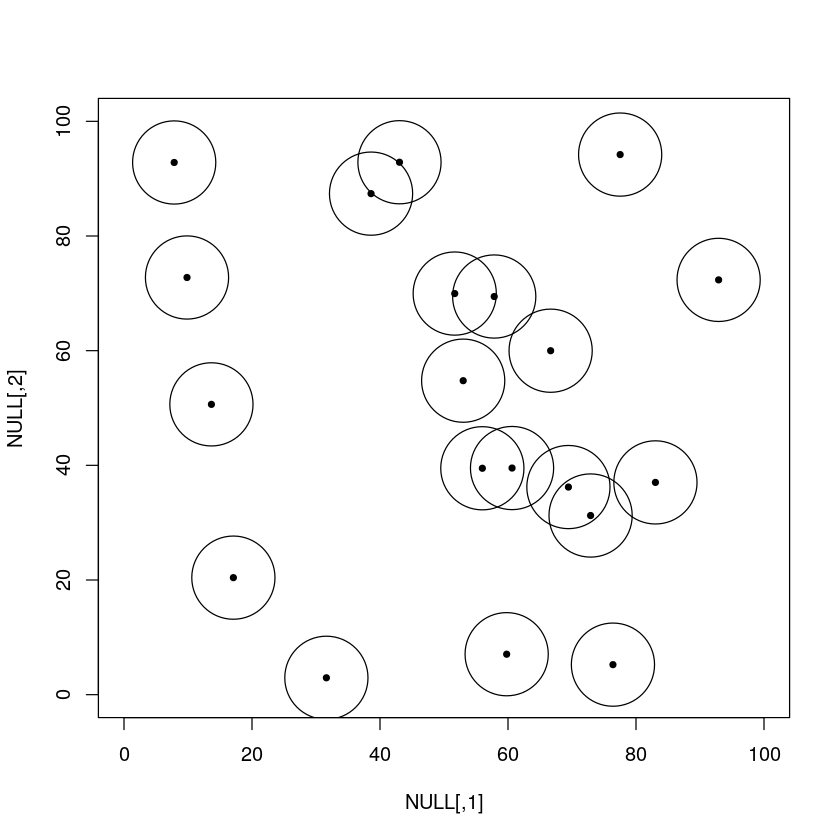

In [234]:
plot(dataTSP,xlim=c(0,100), ylim=c(0,100), pch=20)
symbols(dataTSP, circles=rep(radius,noPts), add=T, inches=F)
branchNo = 14
for (all in current_tree[[branchNo]]){
    pt <- values(pointSet, keys =all)
    points(pt[[1]],pt[[2]], col="3", pch=2)
}


In [216]:
choose_new_edge <- function(forward_edge, backward_edge, main){
    f_vertex <- forward_edge[[2]]
    b_vertex <- backward_edge[[1]]
    common <- forward_edge[[2]]
    compare <- current_tree[[main]]
    
    f_min <- Inf
    f_replace <- NULL
    b_min <- Inf
    b_replace <- NULL
    
    vPt_f <-values(pointSet, keys=f_vertex) 
    vPt_b <-values(pointSet, keys=b_vertex) 
    vPt_c <-values(pointSet, keys =common)
    
    for (vertex in compare){
        if (vertex != common){
            if (f_min == Inf){
                f_min <- dist_pts(vPt_f , vPt_c)
                b_min <- dist_pts(vPt_b, vPt_c)
            } else {
                dist_f <-dist_pts(vPt_f , vPt_c)
                if (dist_f < f_min){
                    f_min <- dist_f
                    f_replace <- vertex
                } 
                dist_b <- dist_pts(vPt_b , vPt_c)
                if (dist_b < b_min){
                    b_min <- dist_b
                    b_replace <- vertex
                }
            }  
        }
    }
    
    if (f_min <= b_min){
        return(list("f", f_replace))
    } else {
        return(list("b", b_replace))
    }
    
}

end_points_det <- function(cluster_tour, connections){
    merge <- hash()
    for (pt_index in 1:length(cluster_tour)){
        main <-cluster_tour[[pt_index]]
        
        if (pt_index == length(cluster_tour)){
            forward <- cluster_tour[[1]]
            backward <- cluster_tour[[pt_index - 1]]
            
        } else {
            if (pt_index == 1){
                forward <- cluster_tour[[pt_index+1]]
                backward <- cluster_tour[[length(cluster_tour)]]

                
            } else {
                forward <- cluster_tour[[pt_index+1]]
                backward <-cluster_tour[[pt_index-1]]

                }
        }
        forward_edge <- connections[[sprintf("%s-%s",main, forward)]]
        backward_edge <- connections[[sprintf("%s-%s",backward, main)]]
        
        if (forward_edge[[1]] == backward_edge[[2]]){
            if (length(current_tree[[main]]) != 1){
                compare_result <-  choose_new_edge(forward_edge, backward_edge, main)
                if (compare_result[[1]] == "f"){
                    forward_edge[[1]] <- compare_result[[2]]
                    
                } else {
                    backward_edge[[2]] <- compare_result[[2]]
                } 
            }
        } 
        merge[[toString(main)]] <-list(backward_edge[[2]],forward_edge[[1]] )
        
        
        
    }
    return(merge)
}
end_points_list<- end_points_det(cluster_tour, connections)
end_points_list

<hash> containing 13 key-value pair(s).
  1 : 1 1
  10 : 15 15
  11 : 16 16
  12 : 19 19
  13 : 20 20
  2 : 2 12
  3 : 14 17
  4 : 4 4
  5 : 6 6
  6 : 18 8
  7 : 9 9
  8 : 11 11
  9 : 12 12

In [217]:
end_points_list[["2"]][[1]]

[1] 2

In [218]:
current_tree


[[1]]
[[1]][[1]]
[1] 1


[[2]]
[[2]][[1]]
[1] 2

[[2]][[2]]
[1] 5

[[2]][[3]]
[1] 10


[[3]]
[[3]][[1]]
[1] 3

[[3]][[2]]
[1] 13

[[3]][[3]]
[1] 17

[[3]][[4]]
[1] 14

[[3]][[5]]
[1] 7


[[4]]
[[4]][[1]]
[1] 4


[[5]]
[[5]][[1]]
[1] 6


[[6]]
[[6]][[1]]
[1] 8

[[6]][[2]]
[1] 18


[[7]]
[[7]][[1]]
[1] 9


[[8]]
[[8]][[1]]
[1] 11


[[9]]
[[9]][[1]]
[1] 12


[[10]]
[[10]][[1]]
[1] 15


[[11]]
[[11]][[1]]
[1] 16


[[12]]
[[12]][[1]]
[1] 19


[[13]]
[[13]][[1]]
[1] 20

In [239]:
add_end_points <- function(tsp, end_points){
    constant <- rep(c(Inf), nrow(as.matrix(tsp)) +1)
    constant[[end_points[[1]]]] <- 0
    constant[[end_points[[2]]]] <- 0
    tsp <-insert_dummy(tsp, 1, const =constant, inf = Inf, label = "dummy")
    return(tsp)
}

all_solutions <- list()
for (branchNo in 1:length(current_tree)){
    pts  <- data.frame(x=c(), y=c())
    if ( length(current_tree[[branchNo]]) <=2){
        if (length(current_tree[[branchNo]]) == 1){

            all_solutions <- append(all_solutions, list(list(1)))
        }

        if (length(current_tree[[branchNo]]) == 2){
            all_solutions <- append(all_solutions, list(list(2,1)))
        }

    }else{
        end_points <- end_points_list[[toString(branchNo)]]
        end_points_pos <-list()
        print(length(current_tree[[branchNo]]))
        print(current_tree[[branchNo]])
        for (pt in current_tree[[branchNo]]){
            if (pt %in% end_points){
                end_points_pos <- append(end_points_pos, match(pt,current_tree[[branchNo]] ))
            }
            pt_data <- values(pointSet, keys=pt)
            pts <- rbind(pts, c(pt_data[[1]],pt_data[2]))           
        }
                
        tsp_subcase <- TSP(dist(pts))
        end_points <- end_points_list[[toString(branchNo)]]

        tsp_subcase <- add_end_points(tsp_subcase, end_points_pos)
        tour <-  solve_TSP(tsp_subcase)
        all_solutions <- append(all_solutions, list(as.list(as.integer(tour))))
    }
}
all_solutions

[1] 3
[[1]]
[1] 2

[[2]]
[1] 5

[[3]]
[1] 10



ERROR: Error in end_points[[2]]: subscript out of bounds


In [220]:
all_solutions

[[1]]
[[1]][[1]]
[1] 1

In [180]:
to_global <- function(tour_list, main){
        
        for (tour_index in 1:length(tour_list)){
                for (vertex_index in 1:length(tour_list[[tour_index]])){
                        vertex <- as.integer(tour_list[[tour_index]][vertex_index])
                       
                        tour_list[[tour_index]][vertex_index] <- main[[tour_index]][vertex]
                }
        }
        return(tour_list)
}

filter_before_merge <- function(tour_list, end_points_list){
    for (index in 1:length(tour_list)){
        sol <- tour_list[[index]]
        sol <- sol [lengths(sol) != 0]
        start <- end_points_list[[toString(index)]][[1]]
        end <- end_points_list[[toString(index)]][[2]]
        start_pos <- match(start, sol)

        end_pos <- match(end, sol)

        if (start_pos < end_pos){
            if (start_pos != 1 & end_pos != length(sol)){
                sol <- append(rev(sol[1:start_pos]), rev(sol[end_pos:length(sol)]))
                } 
        } else {
            
            if (start_pos == length(sol) & end_pos == 1){
                sol <- rev(sol)
            } else {
                sol <- append(rev(sol[1:end_pos]), rev(sol[start_pos:length(sol)]))
                sol <- rev(sol)
             }
        
        }
        tour_list[[index]] <- sol
    }
    return(tour_list)
} 

to_global_subtours <- to_global(all_solutions, current_tree)
all_subtours <- filter_before_merge(to_global_subtours,end_points_list)


In [181]:
cluster_tour

object of class ‘TOUR’ 
result of method ‘concorde’ for 10 cities
tour length: 271.9453

In [182]:
merge_all <- function(formatted_all_subtours, cluster_tour){
    merged_tour <- list()
    for (branch in cluster_tour){
        merged_tour <- append(merged_tour, all_subtours[[branch]])
    }
    print(as.integer(merged_tour))
    return(as.TOUR(as.integer(merged_tour)))
}
merged_tour <-merge_all(all_subtours, cluster_tour)
merged_tour

 [1] 19  1 20  6 15  9  4  8 18 16 12  2  5 10 11 17  3 13  7 14


object of class ‘TOUR’ 
result of method  for 20 cities
tour length: unknown

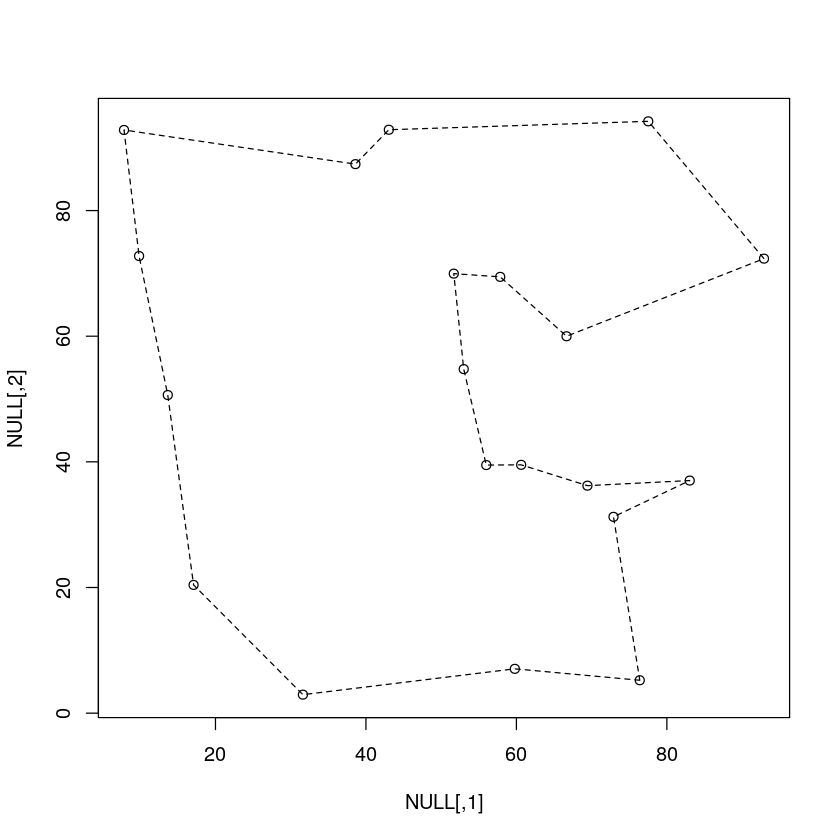

In [183]:
plot(dataTSP, merged_tour)

In [ ]:

cluster_tour
rev(cluster_tour)

In [ ]:
match(8,rev(cluster_tour))

In [893]:
constant <- rep(c(Inf), nrow(as.matrix(tsp)))
constant[[2]] <- 0
constant

[1] Inf   0 Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf Inf
[20] Inf

In [896]:
test<-all_subtours[[2]]
test

[[1]]
[1] 2

[[2]]
NULL

[[3]]
[1] 14

[[4]]
[1] 7

[[5]]
[1] 13

[[6]]
[1] 3

[[7]]
[1] 17

[[8]]
[1] 11

[[9]]
[1] 10

[[10]]
[1] 5

In [899]:
testList<-test[lengths(test) != 0]
testList

[[1]]
[1] 2

[[2]]
[1] 14

[[3]]
[1] 7

[[4]]
[1] 13

[[5]]
[1] 3

[[6]]
[1] 17

[[7]]
[1] 11

[[8]]
[1] 10

[[9]]
[1] 5

In [903]:
testList[2:length(testList)] <- rev(testList[2:length(testList)])
testList

[[1]]
[1] 2

[[2]]
[1] 14

[[3]]
[1] 7

[[4]]
[1] 13

[[5]]
[1] 3

[[6]]
[1] 17

[[7]]
[1] 11

[[8]]
[1] 10

[[9]]
[1] 5

In [907]:
append(rev(testList[1:1]), rev(testList[2:length(testList)]))

[[1]]
[1] 2

[[2]]
[1] 5

[[3]]
[1] 10

[[4]]
[1] 11

[[5]]
[1] 17

[[6]]
[1] 3

[[7]]
[1] 13

[[8]]
[1] 7

[[9]]
[1] 14

In [933]:
test<-to_global(all_solutions, current_tree)
sol <- test[[2]][lengths(test[[2]])!=0]
start <- end_points_list[['2']][[1]]
end <- end_points_list[['2']][[2]]
start_pos <- match(start, sol)
end_pos <- match(end, sol)

In [934]:
sol

[[1]]
[1] 2

[[2]]
[1] 14

[[3]]
[1] 7

[[4]]
[1] 13

[[5]]
[1] 3

[[6]]
[1] 17

[[7]]
[1] 11

[[8]]
[1] 10

[[9]]
[1] 5

In [935]:
sol <- append(rev(sol[1:start_pos]), rev(sol[end_pos:length(sol)]))


In [936]:
sol

[[1]]
[1] 2

[[2]]
[1] 5

[[3]]
[1] 10

[[4]]
[1] 11

[[5]]
[1] 17

[[6]]
[1] 3

[[7]]
[1] 13

[[8]]
[1] 7

[[9]]
[1] 14